In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os 
os.chdir('/content/drive/MyDrive/Eyes datasets')
print('We are inside', os.getcwd())



We are inside /content/drive/MyDrive/Eyes datasets


In [ ]:
import pickle
def load_data():
    file = open('df_train', 'rb')
    df_train = pickle.load(file)
    file.close()

    file = open('df_test', 'rb')
    df_test = pickle.load(file)
    file.close()
    
    return df_train, df_test

In [ ]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')

(2930, 4) (366, 4) 



In [ ]:
df_train.head()

,id_code,diagnosis,file_path,file_name
0,1ae8c165fd53,2,dataset/train_images/1ae8c165fd53.png,1ae8c165fd53.png
1,1b329a127307,1,dataset/train_images/1b329a127307.png,1b329a127307.png
2,1b32e1d775ea,4,dataset/train_images/1b32e1d775ea.png,1b32e1d775ea.png
3,1b3647865779,0,dataset/train_images/1b3647865779.png,1b3647865779.png
4,1b398c0494d1,0,dataset/train_images/1b398c0494d1.png,1b398c0494d1.png


In [ ]:
df_test.head()

,id_code,diagnosis,file_path,file_name
0,e4dcca36ceb4,0,./dataset/test_images/e4dcca36ceb4.png,e4dcca36ceb4.png
1,e4e343eaae2a,2,./dataset/test_images/e4e343eaae2a.png,e4e343eaae2a.png
2,e4f12411fd85,4,./dataset/test_images/e4f12411fd85.png,e4f12411fd85.png
3,e50b0174690d,0,./dataset/test_images/e50b0174690d.png,e50b0174690d.png
4,e5197d77ec68,0,./dataset/test_images/e5197d77ec68.png,e5197d77ec68.png


In [ ]:
# Model parameters
IMG_SIZE = 512
BATCH_SIZE = 8
#EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen= ImageDataGenerator(rescale=1./255, validation_split=0.2, horizontal_flip=True)
 
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

train_generator= train_datagen.flow_from_dataframe(dataframe= df_train,
                                                     directory= "/content/drive/MyDrive/Eyes datasets/train_images_preprocessed",
                                                     x_col= "file_name",
                                                     y_col= "diagnosis",
                                                     batch_size= BATCH_SIZE,
                                                     class_mode= "categorical",
                                                     target_size= (HEIGHT,WIDTH),
                                                     subset= 'training'
                                                     )

Found 2344 validated image filenames belonging to 5 classes.


In [ ]:
  valid_generator= train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="/content/drive/MyDrive/Eyes datasets/train_images_preprocessed",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

Found 586 validated image filenames belonging to 5 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(dataframe= df_test,
                                                    directory= "./test_images_resized_preprocessed/",
                                                    x_col= "file_name", 
                                                    target_size= (HEIGHT, WIDTH),
                                                    batch_size=1,
                                                    shuffle=False,
                                                    class_mode= None
                                                    )

Found 366 validated image filenames.


Model Building

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

Resnet50

In [ ]:
from keras.utils.traceback_utils import include_frame
def create_model(input_shape, n_out):
  input_tensor= Input(shape= input_shape)
  base_model = ResNet50(weights= None, include_top= False, input_tensor= input_tensor)
  base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

  x= GlobalAveragePooling2D()(base_model.output)  #It will return the average of feature value instead of sliding over it. 
  x= Dropout(0.5)(x)
  x= Dense(2048, activation='relu')(x)
  x= Dropout(0.5)(x)

  final_output= Dense(n_out, activation='softmax', name= 'final_output')(x)
  model= Model(input_tensor, final_output)

  return model

In [ ]:
# assigning parameters

model= create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out= N_CLASSES)

#Turn off weights 

for layer in model.layers:
  layer.trainable= False

#train 5 layers only 

for i in range(-5,0):
  model.layers[i].trainable= True

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
print("Train step size:", STEP_SIZE_TRAIN, '\n')
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("valid step size:", STEP_SIZE_VALID)

Train step size: 293 

valid step size: 73


In [ ]:
#Compile the model 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
model.compile(optimizer= Adam(learning_rate= WARMUP_LEARNING_RATE), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
#Fit into the model 

history_warmup = model.fit(train_generator,
                           steps_per_epoch= STEP_SIZE_TRAIN,
                           validation_data= valid_generator,
                           validation_steps=STEP_SIZE_VALID, 
                           epochs= WARMUP_EPOCHS,
                           verbose=1
                           ).history

Epoch 1/2
293/293 [==============================] - 1689s 6s/step - loss: 1.9199 - accuracy: 0.4381 - val_loss: 1.3527 - val_accuracy: 0.4623
Epoch 2/2
293/293 [==============================] - 40s 135ms/step - loss: 1.3431 - accuracy: 0.4855 - val_loss: 1.2460 - val_accuracy: 0.5034


In [ ]:
# Training all the layers 

for layer in model.layers:
  layer.trainable= True

Erl= EarlyStopping(monitor= 'val_loss', mode= 'min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop= ReduceLROnPlateau(monitor= 'val_loss', mode= 'min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
#rlrop will reduce the learning rate by DECAY_DROP factor

callback_list= [Erl, rlrop]

optimizer= Adam(learning_rate= LEARNING_RATE)
model.compile(optimizer= optimizer, loss= "binary_crossentropy", metrics= ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history_finetunning= model.fit(train_generator, 
                               steps_per_epoch= STEP_SIZE_TRAIN,
                               validation_data=valid_generator,
                               validation_steps=STEP_SIZE_VALID,
                               epochs= 40,
                               callbacks= callback_list,
                               verbose=1
                               ).history

Epoch 1/40
293/293 [==============================] - 52s 153ms/step - loss: 0.1409 - accuracy: 0.8588 - val_loss: 0.2227 - val_accuracy: 0.7637 - lr: 1.0000e-04
Epoch 2/40
293/293 [==============================] - 43s 147ms/step - loss: 0.1271 - accuracy: 0.8724 - val_loss: 0.1959 - val_accuracy: 0.7860 - lr: 1.0000e-04
Epoch 3/40
293/293 [==============================] - 42s 145ms/step - loss: 0.0991 - accuracy: 0.9061 - val_loss: 0.2257 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 4/40
293/293 [==============================] - 43s 146ms/step - loss: 0.0920 - accuracy: 0.9078 - val_loss: 0.3362 - val_accuracy: 0.7175 - lr: 1.0000e-04
Epoch 5/40
293/293 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9279
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
293/293 [==============================] - 44s 150ms/step - loss: 0.0800 - accuracy: 0.9279 - val_loss: 0.2819 - val_accuracy: 0.7637 - lr: 1.0000e-04
Epoch 6/40
293/293 [=========

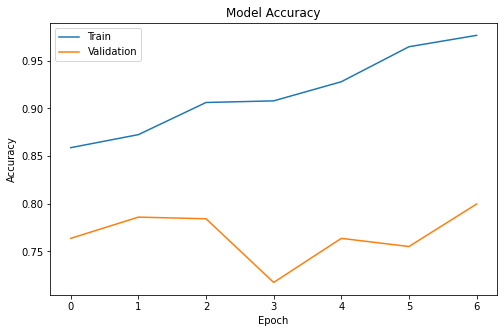

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
#Save the model 

model.save('Eyes_model.h5')

In [ ]:
from keras.models import load_model
model = load_model('Eyes_model.h5')


Prediction on Train data

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train,
                                                          directory="./train_images_preprocessed/",
                                                          x_col="file_name",
                                                          target_size= (HEIGHT,WIDTH),
                                                          batch_size=1,
                                                          shuffle= False,
                                                          class_mode=None
                                                          )

STEP_SIZE_COMPLETE= complete_generator.n//complete_generator.batch_size
train_preds = model.predict(complete_generator, steps= STEP_SIZE_COMPLETE, verbose=1)
train_preds= [np.argmax(pred) for pred in train_preds]
print('\n Train Prediction completed', '\n')

Found 2930 validated image filenames.
2930/2930 [==============================] - 60s 20ms/step

 Train Prediction completed 



In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.908
Train Accuracy score : 0.885


In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

366/366 [==============================] - 207s 568ms/step


In [ ]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_test['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.849
Test Accuracy score : 0.825


'''
Cohen's kappa coefficient is a statistical measure of inter-rater agreement for qualitative (categorical) items. It is generally thought to be a more 
robust measure than simple percent agreement calculation since κ takes into account the agreement occurring by chance.
'''

In [ ]:
# Accuracy on validation Data 
val_loss, val_accuracy = model.evaluate(valid_generator)

74/74 [==============================] - 9s 112ms/step - loss: 0.1992 - accuracy: 0.7782


In [ ]:
# Printing the validation results
print('Val loss: {0:.4f}. Val accuracy: {1:.2f}%'.format(val_loss, val_accuracy*100.))

Val loss: 0.1992. Val accuracy: 77.82%


In [ ]:
def plot_conf_matrix(true, pred, classes):
  cf = confusion_matrix(true, pred)

  df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
  plt.figure(figsize=(10,6))
  sns.set(font_scale=1.4)
  sns.heatmap(df_cm, annot= True, annot_kws={'size':16}, xticklabels= classes, yticklabels= classes, fmt='g')
  plt.show()

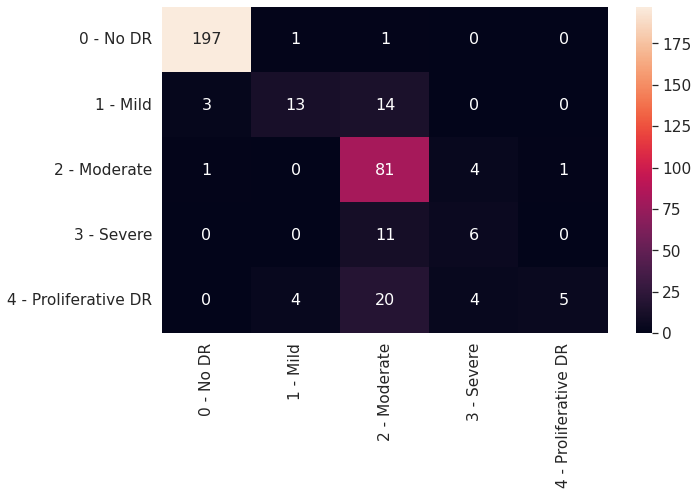

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_test['diagnosis'].astype(int)),test_labels,labels)